In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tifffile

from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.measure import find_contours
from skimage.segmentation import relabel_sequential
import random

import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Sample n_samples number of labels to measure for each frame
def sample_labels_and_measure(frame, frame_index, n_samples=500):
    label_ids = np.unique(frame)
    label_ids = label_ids[label_ids != 0]  # Exclude background

    if len(label_ids) > n_samples:
        random.seed(frame_index) # seed for reproducibility
        sampled_ids = random.sample(list(label_ids), n_samples)
    else:
        sampled_ids = label_ids

    # Keep only the sampled labels
    sampled_frame = np.where(np.isin(frame, sampled_ids), frame, 0)

    # Measure properties only for sampled labels
    props = regionprops_table(sampled_frame.astype(np.int32), properties=['label', 'area', 'eccentricity'])

    # Add frame number
    df = pd.DataFrame(props)
    df['frame'] = frame_index
    return df

In [3]:
# Extract region properties from labeled image
def get_properties(label_img):
    sampled_stats = []
    
    for i in range(label_img.shape[0]):
        frame = label_img[i]
        df_frame = sample_labels_and_measure(frame, frame_index=i, n_samples=500)
        sampled_stats.append(df_frame)
    
    # Combine into a single DataFrame
    sampled_stats_df = pd.concat(sampled_stats, ignore_index=True)
    return sampled_stats_df

In [4]:
# Generate eccentricity vs. area scatter plot by frame
def show_ecc_area_scatter(props_df):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        props_df['area'],
        props_df['eccentricity'],
        c=props_df['frame'],
        cmap='plasma',
        alpha=0.6,
        edgecolor='none'
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label('Frame number')
    plt.xlabel('Area (px²)')
    plt.ylabel('Eccentricity')
    plt.title('Object Properties Across All Frames')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# Generate KDE plot ("smoothed" histogram) for area distribution by frame
def show_kde_plot(props_df):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(
        data=props_df,
        x="area",
        hue="frame",
        palette="plasma",
        common_norm=False,
        fill=False, # True for filled curves (instead of lines)
        alpha=0.7,
        linewidth=1.2,
        clip=(0, None)
    )
    
    plt.xscale("log")  # optional: better view of small-object tail
    plt.xlabel("Area (px², log scale)")
    plt.ylabel("Density")
    plt.title("Smoothed Area Distributions by Frame (KDE)")
    plt.tight_layout()
    plt.show()

In [6]:
# Filter small labeled objects in each frame using min_size (in pixel squared) cutoff
def filter_small_objects(label_img, min_size):
    filtered_label_img = np.zeros_like(label_img, dtype=np.int32)
    
    for i in range(label_img.shape[0]):
        frame = label_img[i]
        props = regionprops(frame.astype(np.int32)) 
        filtered_frame = np.zeros_like(frame, dtype=np.int32)
        
        label_id = 1
        for prop in props:
            if prop.area >= min_size:
                filtered_frame[frame == prop.label] = label_id
                label_id += 1

        # Relabel to ensure labels are contiguous and start at 1
        filtered_label_img[i], _, _ = relabel_sequential(filtered_frame)
                
    return filtered_label_img

In [7]:
# Filter small labeled objects in each frame using a dynamically determined threshold based on area distribution in each frame
def filter_small_objects_percentile(label_img, percentile):
    filtered_label_img = np.zeros_like(label_img, dtype=np.uint32)
    num_frames = label_img.shape[0]
    
    for i in range(num_frames):
        frame = label_img[i]
        props = regionprops(frame.astype(np.int32))
        
        if not props:
            continue

        areas = np.array([p.area for p in props])
        threshold = np.percentile(areas, percentile)

        filtered_frame = np.zeros_like(frame, dtype=np.uint32)
        label_id = 1
        
        for prop in props:
            if prop.area >= threshold:
                filtered_frame[frame == prop.label] = label_id
                label_id += 1
        
        # Optional: Relabel to ensure labels are contiguous and start at 1
        filtered_label_img[i], _, _ = relabel_sequential(filtered_frame)
    
    return filtered_label_img

In [8]:
# Visualize original labeled image and filtered labeled image side by side, for a given frame index
def show_label_comparison_with_boundaries(original_labels, filtered_labels, frame_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    titles = ["Original Labels", "Filtered Labels"]
    labels = [original_labels, filtered_labels]

    for i, ax in enumerate(axes):
        frame = labels[i][frame_idx]
        ax.imshow(frame, cmap='nipy_spectral')
        ax.set_title(f"{titles[i]} (Frame {frame_idx})")
        ax.axis('off')

        # Overlay contours
        for region_id in np.unique(frame):
            if region_id == 0:
                continue  # skip background
            mask = (frame == region_id)
            contours = find_contours(mask.astype(float), level=0.5)
            for contour in contours:
                ax.plot(contour[:, 1], contour[:, 0], color='white', linewidth=0.8)

    plt.suptitle("Label Comparison with Object Boundaries", fontsize=14)
    plt.tight_layout()
    plt.show()

In [19]:
'''
Workflow for filtering: load images
                        get properties
                        plot area distribution and/or eccentricity vs. area
                        filter segmentation and visualize filtered
                        save filtered result
'''

# Load labeled image stacks
label_path = '/home/vil945/live_cell_imaging/2025-03-26_live_cell_imaging'
YFP_path = os.path.join(label_path, '2025-03-26_YFP', '2025-03-26_YFP_segmented')
PI_path = os.path.join(label_path, '2025-03-26_PI', '2025-03-26_PI_segmented')
CTV_path = os.path.join(label_path, '2025-03-26_CTV', '2025-03-26_CTV_segmented')

YFP_stack = tifffile.imread(f'{YFP_path}/segmented_2025-03-26_titration_xy3-C3.tif')
PI_stack = tifffile.imread(f'{PI_path}/segmented_2025-03-26_titration_xy3-C2.tif')
CTV_stack = tifffile.imread(f'{CTV_path}/segmented_2025-03-26_titration_xy3-C4.tif')

# Get properties

PI_props = get_properties(PI_stack)
CTV_props = get_properties(CTV_stack)
YFP_props = get_properties(YFP_stack)

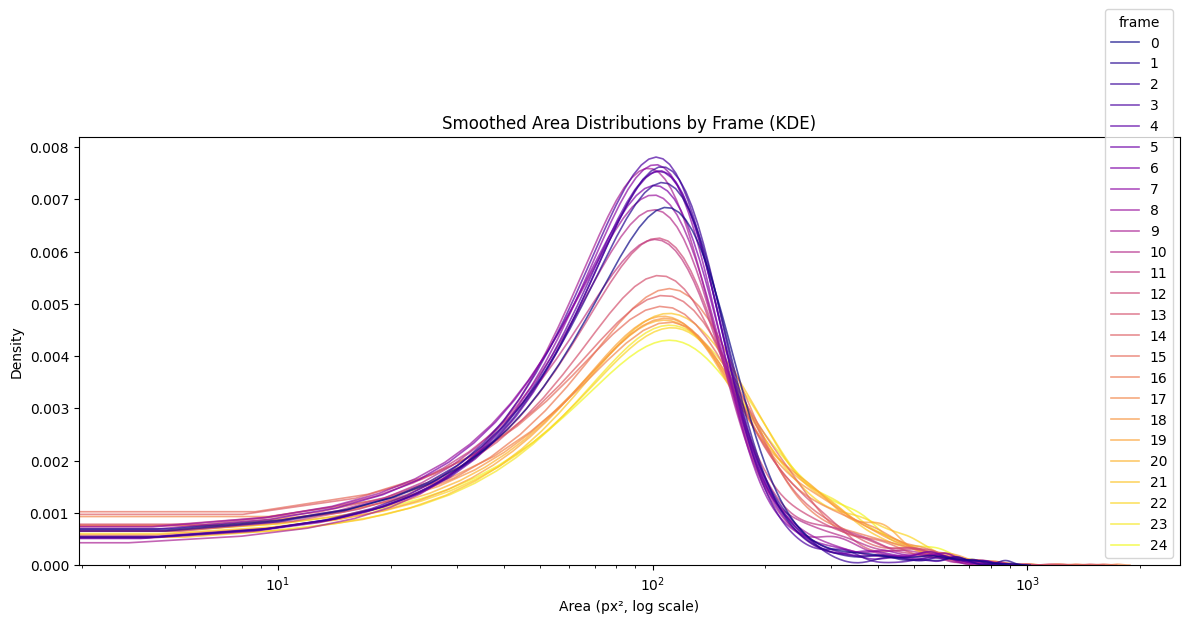

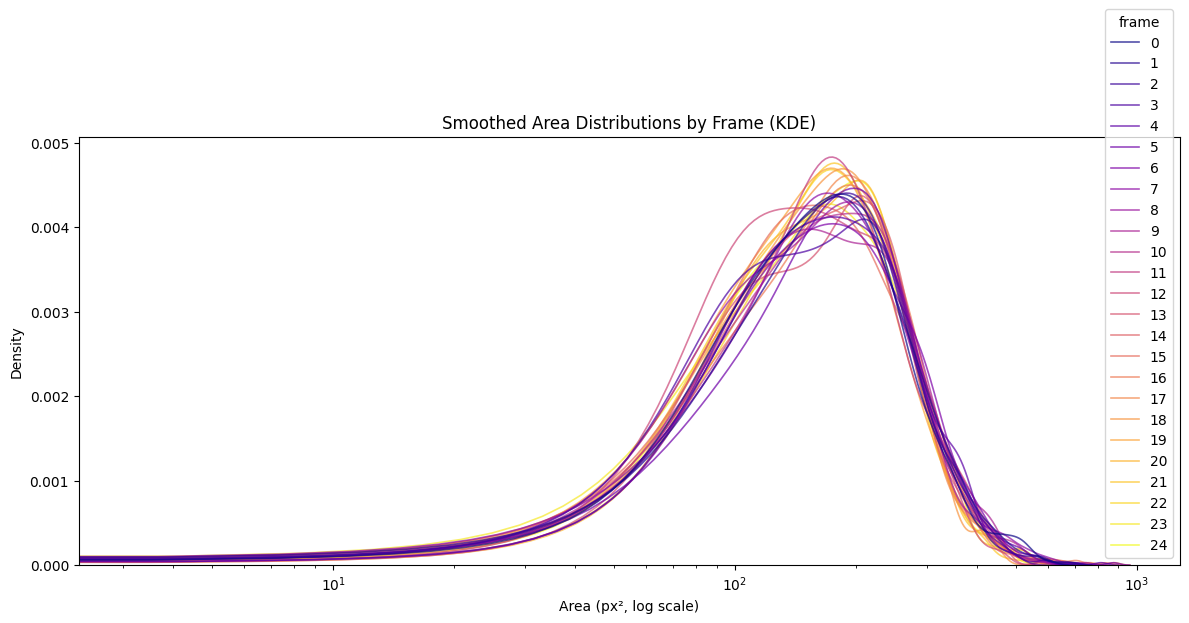

In [20]:
# Visualize area distribution of PI channel and CTV channel
# Use CTV channel area distribution to see where to set the cutoff for filtering PI channel segmentation
show_kde_plot(PI_props)
show_kde_plot(CTV_props)

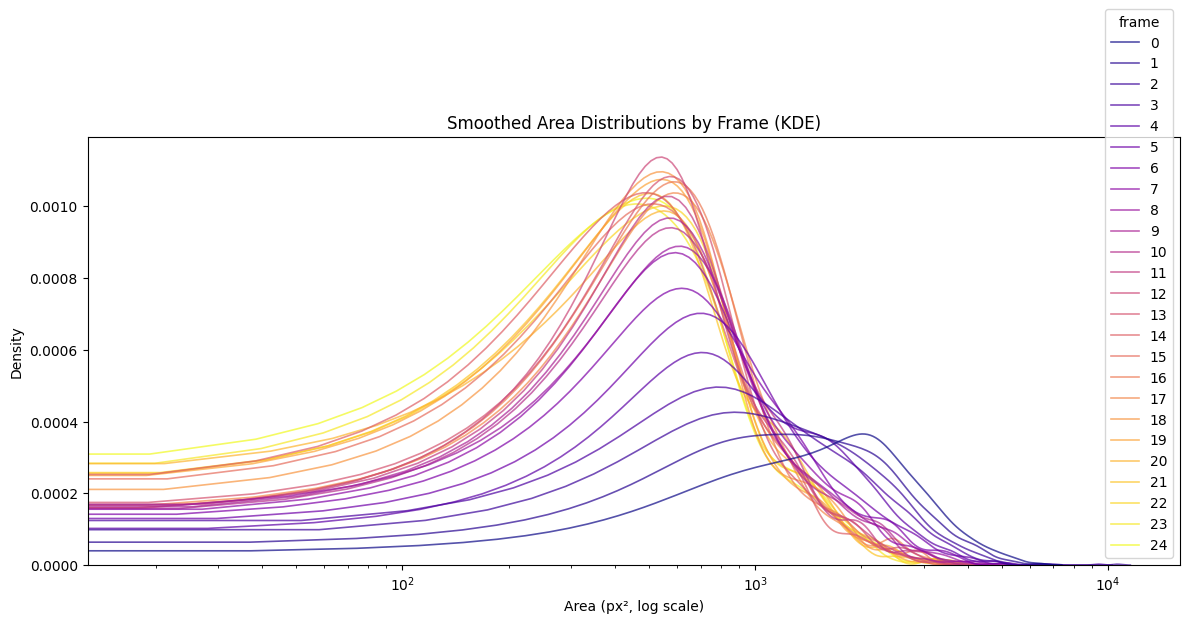

In [21]:
# Visualize area distribution of YFP channel
show_kde_plot(YFP_props)

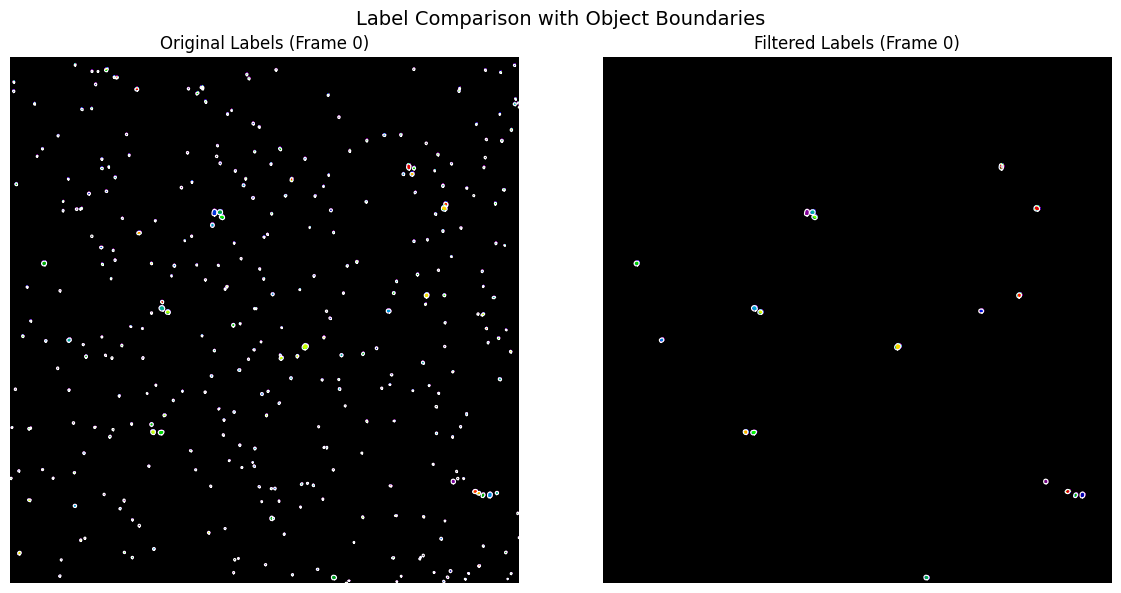

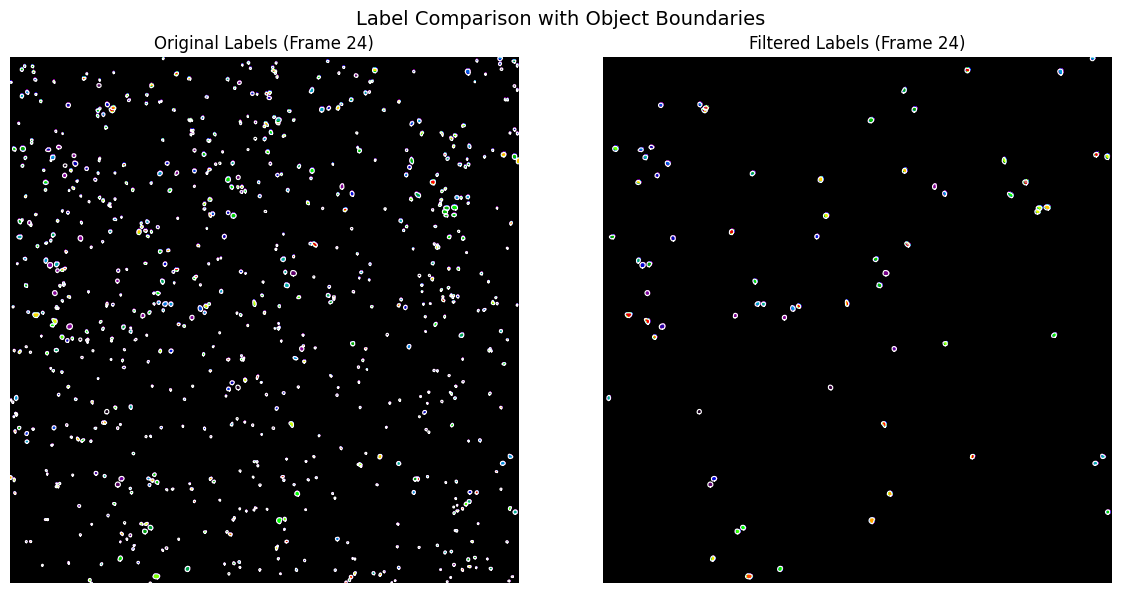

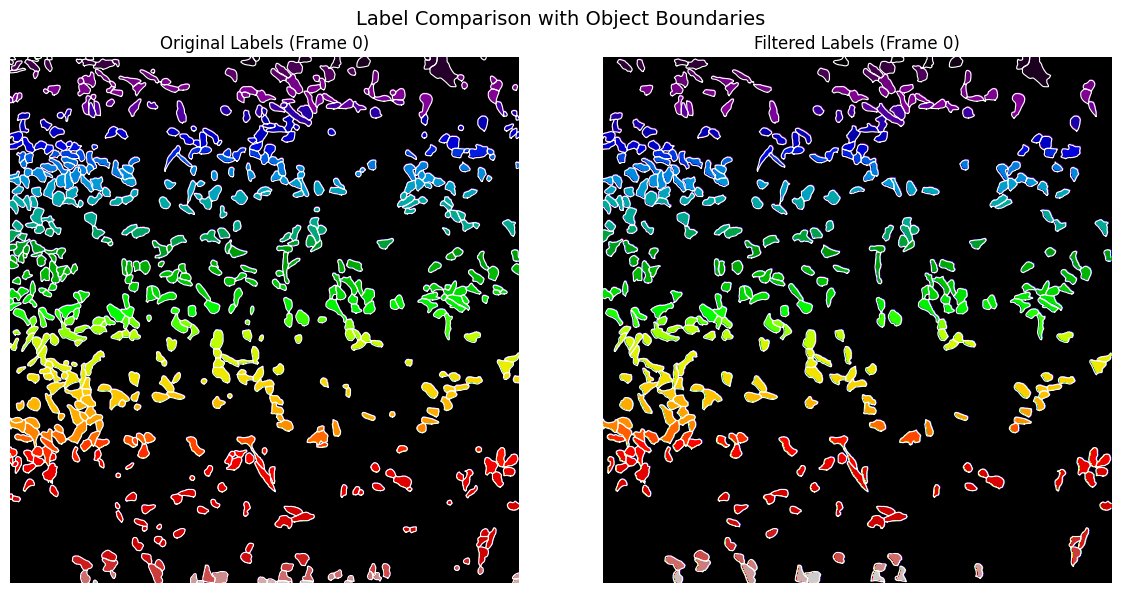

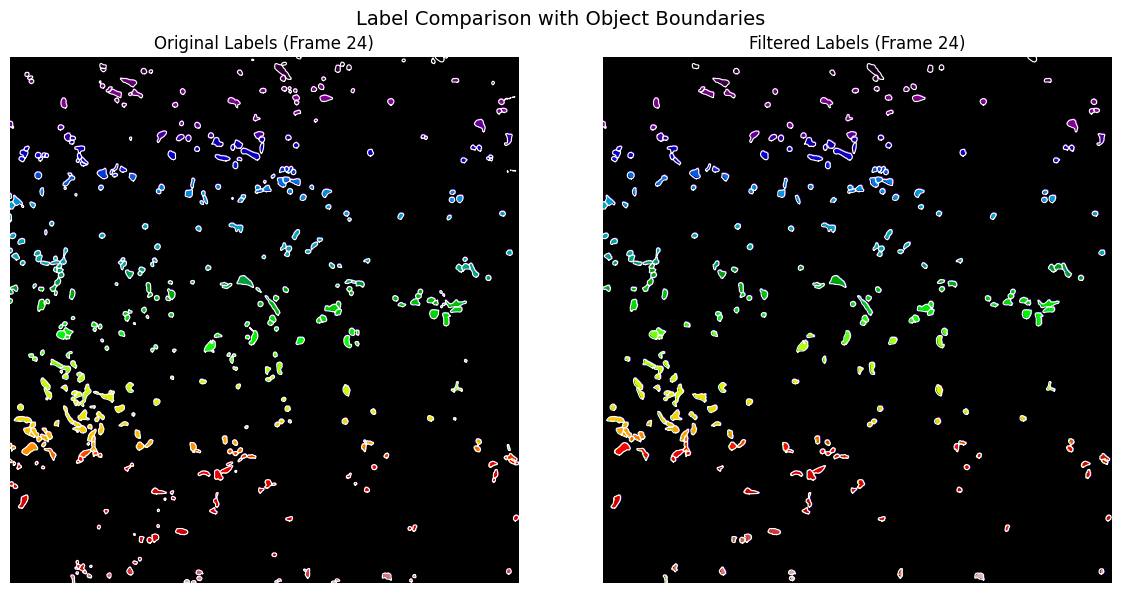

In [22]:
# Filter labeled images and visualize filtered results (in comparison to original images)
PI_filtered = filter_small_objects(PI_stack, 400) # uniform cutoff for PI channel
YFP_filtered = filter_small_objects_percentile(YFP_stack, 40) # per-frame dynamic cutoff for YFP channel

show_label_comparison_with_boundaries(PI_stack, PI_filtered, 0)
show_label_comparison_with_boundaries(PI_stack, PI_filtered, 24)
show_label_comparison_with_boundaries(YFP_stack, YFP_filtered, 0)
show_label_comparison_with_boundaries(YFP_stack, YFP_filtered, 24)

In [23]:
# Save filtered label images
filter_folder = os.path.join(label_path, 'filtered_segmentation')
os.makedirs(filter_folder, exist_ok=True)

tifffile.imwrite(f'{filter_folder}/2025-03-26_titration_xy3_PI_filtered_labels.tif', PI_filtered.astype(np.uint16))
tifffile.imwrite(f'{filter_folder}/2025-03-26_titration_xy3_YFP_filtered_labels.tif', YFP_filtered.astype(np.uint16))